In [19]:
# directory
import os
import zipfile
import shutil
import random
import itertools
from functools import partial
from tqdm import tqdm

# dataframe
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve
from sklearn.metrics import auc as AUC

# image processing
import cv2
import albumentations as A
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping, Callback, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

SEED = 123
tf.keras.utils.set_random_seed(SEED)
tf.config.experimental.enable_op_determinism()

AUTOTUNE = tf.data.experimental.AUTOTUNE

In [20]:
# with zipfile.ZipFile('archive.zip', 'r') as zip_ref:
#     zip_ref.extractall('breakhis')

In [21]:
df = pd.read_csv('breakhis/Folds.csv')

root_dir = 'breakhis/'

In [22]:
df.head()

,fold,mag,grp,filename
0,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...
1,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...
2,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...
3,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...
4,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...


In [23]:
df = df.rename(columns={'filename': 'path'})

- Folds..csv contains images information that consist of magnitude, group (train, test), and path

before restructuring directory, we will add label to image file name for error analysis later

- It seems that fold is like proportion of train and test. Each folds contains 7909 images. Fold 2 contains most training data than other folds. So, we will choose fold 2.

In [24]:
df = (df[df['fold'] == 2].drop(columns='fold', axis=1)
                         .reset_index(drop=True))

df.shape

(7909, 3)

In [25]:
df['mag'] = df['mag'].astype('str')
df['type'] = df['path'].apply(lambda x: x.split('/')[5])
df['filename'] = df['path'].apply(lambda x: x.split('/')[-1])
df['path'] = df['path'].apply(lambda x: os.path.join('breakhis', x))
# df['label'] = df['path'].apply(lambda x: x.split('/')[4])
df['label'] = df['path'].str.extract("(malignant|benign)")
df['filename'] = df['label'] + '_' + df['filename']
df['class'] = df['label'].apply(lambda x: 1 if x == 'malignant' else 0)

df.head()

,mag,grp,path,type,filename,label,class
0,100,train,breakhis/BreaKHis_v1/histology_slides/breast/b...,adenosis,benign_SOB_B_A-14-22549AB-100-001.png,benign,0
1,100,train,breakhis/BreaKHis_v1/histology_slides/breast/b...,adenosis,benign_SOB_B_A-14-22549AB-100-002.png,benign,0
2,100,train,breakhis/BreaKHis_v1/histology_slides/breast/b...,adenosis,benign_SOB_B_A-14-22549AB-100-003.png,benign,0
3,100,train,breakhis/BreaKHis_v1/histology_slides/breast/b...,adenosis,benign_SOB_B_A-14-22549AB-100-004.png,benign,0
4,100,train,breakhis/BreaKHis_v1/histology_slides/breast/b...,adenosis,benign_SOB_B_A-14-22549AB-100-005.png,benign,0


In [26]:
df['path'][0]

'breakhis/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/100X/SOB_B_A-14-22549AB-100-001.png'

In [27]:
df1 = df[df['grp'] == 'train']
test_df = df[df['grp'] == 'test']

In [28]:
df1.shape, test_df.shape

((5506, 7), (2403, 7))

[Text(0, 0, '1756'), Text(0, 0, '3750')]

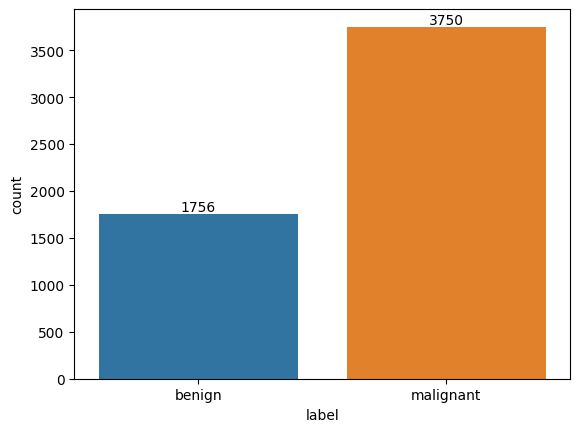

In [29]:
# show malignant and benign size
ax = sns.countplot(data=df1, x='label')
ax.bar_label(ax.containers[0])

## Data Preprocessing

### Define Helper Functions

In [30]:
BATCH_SIZE = 28
IMG_SIZE = 224
IMAGE_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

In [43]:
def load_process_image(file, label):
    """
    Load and preprocess an image from the given file path.

    Parameters:
        file (str): The file path of the image to be loaded.
        label: The label associated with the image.

    Returns:
        img (Tensor): Processed image as a TensorFlow tensor.
        label: The unchanged label associated with the image.
    """
    img = tf.io.read_file(file)
    img = tf.image.decode_png(img, channels=3) # channels 3 = RGB
    # img = tf.image.resize_with_pad(img, IMG_SIZE, IMG_SIZE)

    return img, label


def resize_rescale(image, label):
    """
    Resize and rescale the input image while keeping its label unchanged.

    Parameters:
        image (Tensor): The input image as a TensorFlow tensor.
        label: The label associated with the image.

    Returns:
        img (Tensor): Resized and rescaled image as a TensorFlow tensor.
        label: The unchanged label associated with the image.
    """
    img = tf.cast(image, tf.float32)
    img = tf.image.resize_with_pad(img, IMG_SIZE, IMG_SIZE)
    return img, label


def view_image(ds, col=8, row=2, size=(25,7)):
    """
    Visualize a random subset of images and their labels from a given dataset.

    Parameters:
        ds (tf.data.Dataset): The input dataset containing images and labels.
        col (int): Number of columns in the visualization grid (default is 8).
        row (int): Number of rows in the visualization grid (default is 2).
        size (tuple): Figure size (width, height) for the visualization (default is (25, 7)).

    Returns:
        None
    """
    plt.figure(figsize=size)
    plt.subplots_adjust(wspace=0.05, hspace=0.15)
    class_names = ['benign', 'malignant']
    for images, labels in ds.take(1):
        for i in range(col*row):
            ax = plt.subplot(row, col, i + 1)
            shape = str(images[i].numpy().shape)
            plt.imshow(images[i].numpy())
            plt.title(class_names[labels[i].numpy()])
            plt.axis("off") 
    plt.tight_layout
    return None

        
def images_augmentation(img, IMG_SIZE):
    """
    Apply a set of image augmentation transformations to enhance variability.
    source: https://github.com/albumentations-team/albumentations

    Parameters:
        img (Tensor): Input image as a TensorFlow tensor.
        IMG_SIZE (int): Desired size for the augmented image.

    Returns:
        aug_img (Tensor): Augmented and preprocessed image as a TensorFlow tensor.
    """
    transforms = A.Compose([
        A.Rotate(limit=20, p=0.3),
        A.HorizontalFlip(),
        A.VerticalFlip(),
        A.RandomBrightnessContrast(
            p=0.5,
            brightness_limit=0.2, 
            contrast_limit=0.1,
            brightness_by_max=True
        ),
        A.Blur(
            p=0.3, 
            blur_limit=(1, 1)
        ),
    ])
    
    data = {'image': img}
    aug_data = transforms(**data)
    aug_img = aug_data["image"]
    aug_img = tf.cast(aug_img, tf.float32)
    aug_img = tf.image.resize_with_pad(aug_img, IMG_SIZE, IMG_SIZE)
    
    return aug_img


def process_augmentation(image, label, IMG_SIZE):
    """
    Process an image and its label by applying augmentation and resizing
    from images_augmentation function.

    Parameters:
        image (Tensor): Input image as a TensorFlow tensor.
        label: The label associated with the image.
        img_size (int): Desired size for the processed image.

    Returns:
        aug_img (Tensor): Processed and augmented image as a TensorFlow tensor.
        label: The unchanged label associated with the image.
    """
    aug_img = tf.numpy_function(func=images_augmentation, inp=[image, IMG_SIZE], Tout=tf.float32)
    return aug_img, label


def set_shapes(img, label, img_shape=IMAGE_SHAPE):
    """
    The datasets loses its shape after applying a tf.numpy_function, so this is necessary
    for the sequential model and when inheriting from the model class.
    Parameters:
        image (Tensor): Input image as a TensorFlow tensor.
        label: The label associated with the image.
        img_size (int): Desired size for the processed image.
    Returns:
        img (Tensor): Reshaped images after augmentation
        label: The unchanged label associated with the image.
    """
    img.set_shape(img_shape)
    label.set_shape(())
    return img, label

In [44]:
# split data into train and validation
train_df, val_df = train_test_split(df1, test_size=0.2, random_state=SEED)

print(f"Train size: {train_df.shape}")
print(f"Validation size: {val_df.shape}")
print(f"Test size: {test_df.shape}")

Train size: (4404, 7)
Validation size: (1102, 7)
Test size: (2403, 7)


Text(0.5, 1.0, 'Test data')

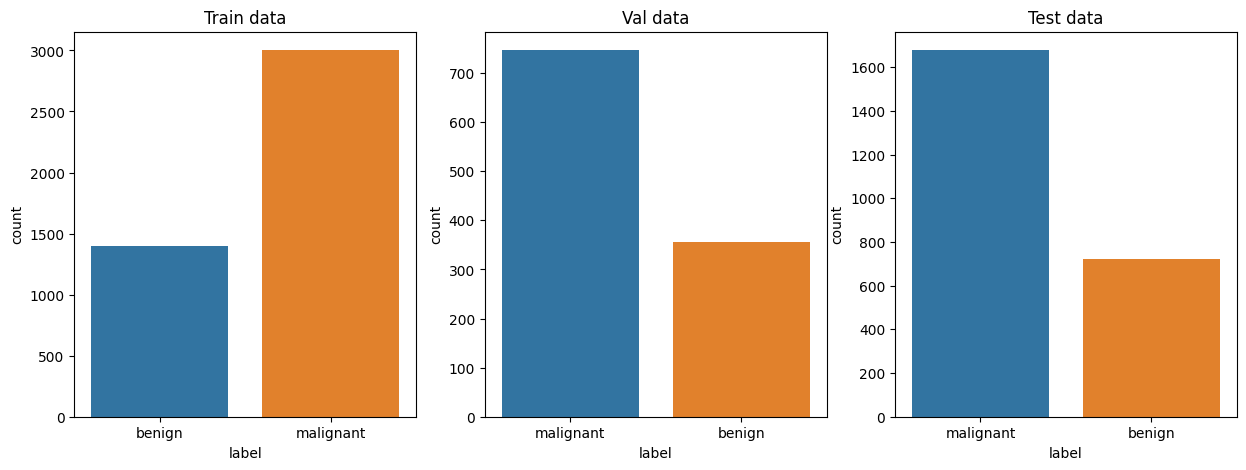

In [45]:
# show size of each label in train, val, and test data
fig, axs = plt.subplots(1,3, figsize=(15,5))
sns.countplot(data=train_df, x='label', ax=axs[0])
axs[0].set_title('Train data')

sns.countplot(data=val_df, x='label', ax=axs[1])
axs[1].set_title('Val data')

sns.countplot(data=test_df, x='label', ax=axs[2])
axs[2].set_title('Test data')

In [46]:
# Creating a TensorFlow Dataset for training data
train_loader = tf.data.Dataset.from_tensor_slices((train_df['path'], train_df['class']))
# Creating a TensorFlow Dataset for validation data
val_loader = tf.data.Dataset.from_tensor_slices((val_df['path'], val_df['class']))

# Shuffling the test dataframe and creating a TensorFlow Dataset for test data
test_df = test_df.sample(frac=1, random_state=SEED)
test_loader = tf.data.Dataset.from_tensor_slices((test_df['path'], test_df['class']))

# setting up the training, validation and test pipeline by applying helper functions 
train_ds = (
    train_loader
    .map(load_process_image, num_parallel_calls=AUTOTUNE)
    .map(partial(process_augmentation, IMG_SIZE=IMG_SIZE), num_parallel_calls=AUTOTUNE) # applying image data augmentation
    .map(set_shapes, num_parallel_calls=AUTOTUNE) 
    .shuffle(961)
    .batch(BATCH_SIZE) # groups consecutive elements from the dataset into batches
    .prefetch(AUTOTUNE) # overlaps the data preprocessing and model execution.
)

val_ds = (
    val_loader
    .map(load_process_image, num_parallel_calls=AUTOTUNE)
    .map(resize_rescale, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

test_ds = (
    test_loader
    .map(load_process_image, num_parallel_calls=AUTOTUNE)
    .map(resize_rescale, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

"""
AUTOTUNE:  
it prefetches a certain number of batches from the dataset, 
allowing the CPU to work on preprocessing the next batch while 
the GPU is still training on the current batch
https://www.tensorflow.org/guide/data_performance
"""

'\nAUTOTUNE:  \nit prefetches a certain number of batches from the dataset, \nallowing the CPU to work on preprocessing the next batch while \nthe GPU is still training on the current batch\nhttps://www.tensorflow.org/guide/data_performance\n'

In [47]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

# Transfer Learning

In [48]:
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2B1
from tensorflow.keras import layers

def build_model():
    pretrained_model = EfficientNetV2B1(include_top=False,
                                      input_shape=IMAGE_SHAPE,
                                      weights='imagenet',
                                      pooling='avg')
    
    # freeze pretrained weight
    pretrained_model.trainable = False
    
    # rebuild top
    inputs = layers.Input(shape=IMAGE_SHAPE)
    # x = BatchNormalization()()
    x = Flatten()(pretrained_model.output)
    x = Dense(32, activation='relu')(x)

    x = Dropout(0.3)(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(pretrained_model.input, outputs, name='EfficientNet')
    
    # model = tf.keras.Sequential([
    #     layers.Input(shape=IMAGE_SHAPE),
    #     layers.RandomBrightness(0.2, seed=SEED),
    #     layers.RandomFlip(seed=SEED),
    #     layers.RandomRotation(0.2, seed=SEED),
    #     pretrained_model,
    #     BatchNormalization(),
    #     Flatten(),
    #     Dense(64, activation='relu'),
    #     Dropout(0.3),
    #     layers.Dense(1, activation="sigmoid")
    # ])
    
    lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
        initial_learning_rate=0.001,
        decay_steps=1200,
        decay_rate=0.35,
    )
    
    model.compile(
        optimizer= tf.keras.optimizers.Adam(learning_rate=lr_schedule),
        loss='binary_crossentropy',
        metrics=[tf.keras.metrics.AUC(name="roc_auc")]
    )
    
    return model

In [49]:
callbacks = [
    EarlyStopping(
        restore_best_weights=True,
        min_delta=1e-4,
        patience=3,
        verbose=1
    ),
    ModelCheckpoint(
        filepath='transfer_learning_model.h5',
        save_best_only=True,
        verbose=1
    )
]

In [51]:
model = build_model()

history = model.fit(
    train_ds,
    epochs=30,
    verbose=1,
    validation_data=val_ds,
    callbacks=[callbacks]
)

Epoch 1/30


2023-08-21 17:21:27.818981: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 570 of 961
2023-08-21 17:21:34.878303: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


157/158 [============================>.] - ETA: 0s - loss: 0.4200 - roc_auc: 0.8605
Epoch 1: val_loss improved from inf to 0.28477, saving model to custom_model3.h5


/home/anggapark/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


158/158 [==============================] - 88s 416ms/step - loss: 0.4197 - roc_auc: 0.8606 - val_loss: 0.2848 - val_roc_auc: 0.9490
Epoch 2/30


2023-08-21 17:22:51.495007: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 600 of 961
2023-08-21 17:22:57.972146: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


157/158 [============================>.] - ETA: 0s - loss: 0.3130 - roc_auc: 0.9254
Epoch 2: val_loss improved from 0.28477 to 0.24441, saving model to custom_model3.h5
158/158 [==============================] - 80s 398ms/step - loss: 0.3129 - roc_auc: 0.9254 - val_loss: 0.2444 - val_roc_auc: 0.9593
Epoch 3/30


2023-08-21 17:24:11.273604: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 670 of 961
2023-08-21 17:24:16.247194: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


157/158 [============================>.] - ETA: 0s - loss: 0.2857 - roc_auc: 0.9380
Epoch 3: val_loss improved from 0.24441 to 0.22403, saving model to custom_model3.h5
158/158 [==============================] - 77s 389ms/step - loss: 0.2853 - roc_auc: 0.9383 - val_loss: 0.2240 - val_roc_auc: 0.9680
Epoch 4/30


2023-08-21 17:25:28.168352: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 709 of 961
2023-08-21 17:25:32.349788: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


157/158 [============================>.] - ETA: 0s - loss: 0.2520 - roc_auc: 0.9522
Epoch 4: val_loss did not improve from 0.22403
158/158 [==============================] - 77s 393ms/step - loss: 0.2520 - roc_auc: 0.9522 - val_loss: 0.2431 - val_roc_auc: 0.9712
Epoch 5/30


2023-08-21 17:26:44.964940: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 653 of 961
2023-08-21 17:26:50.405846: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


157/158 [============================>.] - ETA: 0s - loss: 0.2475 - roc_auc: 0.9548
Epoch 5: val_loss improved from 0.22403 to 0.20158, saving model to custom_model3.h5
158/158 [==============================] - 80s 403ms/step - loss: 0.2471 - roc_auc: 0.9549 - val_loss: 0.2016 - val_roc_auc: 0.9748
Epoch 6/30


2023-08-21 17:28:06.904675: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 594 of 961
2023-08-21 17:28:13.504559: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


157/158 [============================>.] - ETA: 0s - loss: 0.2244 - roc_auc: 0.9612
Epoch 6: val_loss improved from 0.20158 to 0.18188, saving model to custom_model3.h5
158/158 [==============================] - 79s 393ms/step - loss: 0.2241 - roc_auc: 0.9612 - val_loss: 0.1819 - val_roc_auc: 0.9771
Epoch 7/30


2023-08-21 17:29:28.851574: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 683 of 961
2023-08-21 17:29:33.456447: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


157/158 [============================>.] - ETA: 0s - loss: 0.2151 - roc_auc: 0.9661
Epoch 7: val_loss improved from 0.18188 to 0.17737, saving model to custom_model3.h5
158/158 [==============================] - 77s 395ms/step - loss: 0.2148 - roc_auc: 0.9662 - val_loss: 0.1774 - val_roc_auc: 0.9776
Epoch 8/30


2023-08-21 17:30:46.262506: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 630 of 961
2023-08-21 17:30:51.963219: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


157/158 [============================>.] - ETA: 0s - loss: 0.2071 - roc_auc: 0.9687
Epoch 8: val_loss improved from 0.17737 to 0.17161, saving model to custom_model3.h5
158/158 [==============================] - 79s 396ms/step - loss: 0.2077 - roc_auc: 0.9685 - val_loss: 0.1716 - val_roc_auc: 0.9789
Epoch 9/30


2023-08-21 17:32:05.009464: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 683 of 961
2023-08-21 17:32:09.585539: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


157/158 [============================>.] - ETA: 0s - loss: 0.2036 - roc_auc: 0.9690
Epoch 9: val_loss improved from 0.17161 to 0.16584, saving model to custom_model3.h5
158/158 [==============================] - 76s 385ms/step - loss: 0.2033 - roc_auc: 0.9691 - val_loss: 0.1658 - val_roc_auc: 0.9808
Epoch 10/30


2023-08-21 17:33:20.812512: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 702 of 961
2023-08-21 17:33:24.945423: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


157/158 [============================>.] - ETA: 0s - loss: 0.1808 - roc_auc: 0.9763
Epoch 10: val_loss improved from 0.16584 to 0.16219, saving model to custom_model3.h5
158/158 [==============================] - 76s 391ms/step - loss: 0.1816 - roc_auc: 0.9761 - val_loss: 0.1622 - val_roc_auc: 0.9822
Epoch 11/30


2023-08-21 17:34:37.259516: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 699 of 961
2023-08-21 17:34:41.846157: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


157/158 [============================>.] - ETA: 0s - loss: 0.1966 - roc_auc: 0.9718
Epoch 11: val_loss improved from 0.16219 to 0.15498, saving model to custom_model3.h5
158/158 [==============================] - 78s 400ms/step - loss: 0.1967 - roc_auc: 0.9719 - val_loss: 0.1550 - val_roc_auc: 0.9827
Epoch 12/30


2023-08-21 17:35:55.533139: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 642 of 961
2023-08-21 17:36:01.105278: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


157/158 [============================>.] - ETA: 0s - loss: 0.1829 - roc_auc: 0.9754
Epoch 12: val_loss did not improve from 0.15498
158/158 [==============================] - 79s 397ms/step - loss: 0.1829 - roc_auc: 0.9754 - val_loss: 0.1620 - val_roc_auc: 0.9839
Epoch 13/30


2023-08-21 17:37:14.281835: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 611 of 961
2023-08-21 17:37:20.215346: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


157/158 [============================>.] - ETA: 0s - loss: 0.1777 - roc_auc: 0.9768
Epoch 13: val_loss improved from 0.15498 to 0.15495, saving model to custom_model3.h5
158/158 [==============================] - 79s 398ms/step - loss: 0.1783 - roc_auc: 0.9766 - val_loss: 0.1550 - val_roc_auc: 0.9848
Epoch 14/30


2023-08-21 17:38:33.514882: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 661 of 961
2023-08-21 17:38:38.828504: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


157/158 [============================>.] - ETA: 0s - loss: 0.1797 - roc_auc: 0.9762
Epoch 14: val_loss improved from 0.15495 to 0.14899, saving model to custom_model3.h5
158/158 [==============================] - 78s 393ms/step - loss: 0.1797 - roc_auc: 0.9762 - val_loss: 0.1490 - val_roc_auc: 0.9848
Epoch 15/30


2023-08-21 17:39:51.364829: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 621 of 961
2023-08-21 17:39:57.749987: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


157/158 [============================>.] - ETA: 0s - loss: 0.1604 - roc_auc: 0.9822
Epoch 15: val_loss improved from 0.14899 to 0.14453, saving model to custom_model3.h5
158/158 [==============================] - 80s 397ms/step - loss: 0.1609 - roc_auc: 0.9820 - val_loss: 0.1445 - val_roc_auc: 0.9852
Epoch 16/30


2023-08-21 17:41:13.435509: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 654 of 961
2023-08-21 17:41:18.501578: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


157/158 [============================>.] - ETA: 0s - loss: 0.1600 - roc_auc: 0.9815
Epoch 16: val_loss did not improve from 0.14453
158/158 [==============================] - 74s 373ms/step - loss: 0.1600 - roc_auc: 0.9815 - val_loss: 0.1480 - val_roc_auc: 0.9854
Epoch 17/30


2023-08-21 17:42:35.966028: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 612 of 961
2023-08-21 17:42:41.644152: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


157/158 [============================>.] - ETA: 0s - loss: 0.1734 - roc_auc: 0.9783
Epoch 17: val_loss improved from 0.14453 to 0.13685, saving model to custom_model3.h5
158/158 [==============================] - 77s 386ms/step - loss: 0.1733 - roc_auc: 0.9783 - val_loss: 0.1368 - val_roc_auc: 0.9870
Epoch 18/30


2023-08-21 17:43:53.127727: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 645 of 961
2023-08-21 17:43:58.510536: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


157/158 [============================>.] - ETA: 0s - loss: 0.1646 - roc_auc: 0.9804
Epoch 18: val_loss improved from 0.13685 to 0.13598, saving model to custom_model3.h5
158/158 [==============================] - 79s 398ms/step - loss: 0.1644 - roc_auc: 0.9804 - val_loss: 0.1360 - val_roc_auc: 0.9878
Epoch 19/30


2023-08-21 17:45:11.802758: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 658 of 961
2023-08-21 17:45:17.142726: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


157/158 [============================>.] - ETA: 0s - loss: 0.1503 - roc_auc: 0.9833
Epoch 19: val_loss improved from 0.13598 to 0.13519, saving model to custom_model3.h5
158/158 [==============================] - 79s 398ms/step - loss: 0.1503 - roc_auc: 0.9833 - val_loss: 0.1352 - val_roc_auc: 0.9878
Epoch 20/30


2023-08-21 17:46:30.424331: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 626 of 961
2023-08-21 17:46:36.463351: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


157/158 [============================>.] - ETA: 0s - loss: 0.1500 - roc_auc: 0.9838
Epoch 20: val_loss improved from 0.13519 to 0.13142, saving model to custom_model3.h5
158/158 [==============================] - 78s 392ms/step - loss: 0.1501 - roc_auc: 0.9838 - val_loss: 0.1314 - val_roc_auc: 0.9877
Epoch 21/30


2023-08-21 17:47:48.829411: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 647 of 961
2023-08-21 17:47:54.263048: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


157/158 [============================>.] - ETA: 0s - loss: 0.1524 - roc_auc: 0.9835
Epoch 21: val_loss did not improve from 0.13142
158/158 [==============================] - 79s 398ms/step - loss: 0.1524 - roc_auc: 0.9835 - val_loss: 0.1419 - val_roc_auc: 0.9867
Epoch 22/30


2023-08-21 17:49:07.541055: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 707 of 961
2023-08-21 17:49:11.776018: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


157/158 [============================>.] - ETA: 0s - loss: 0.1485 - roc_auc: 0.9843
Epoch 22: val_loss did not improve from 0.13142
158/158 [==============================] - 75s 385ms/step - loss: 0.1484 - roc_auc: 0.9843 - val_loss: 0.1330 - val_roc_auc: 0.9884
Epoch 23/30


2023-08-21 17:50:23.002768: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 686 of 961
2023-08-21 17:50:27.415919: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


157/158 [============================>.] - ETA: 0s - loss: 0.1426 - roc_auc: 0.9851
Epoch 23: val_loss improved from 0.13142 to 0.13020, saving model to custom_model3.h5
158/158 [==============================] - 75s 379ms/step - loss: 0.1426 - roc_auc: 0.9851 - val_loss: 0.1302 - val_roc_auc: 0.9884
Epoch 24/30


2023-08-21 17:51:37.703677: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 660 of 961
2023-08-21 17:51:42.933197: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


157/158 [============================>.] - ETA: 0s - loss: 0.1424 - roc_auc: 0.9856
Epoch 24: val_loss improved from 0.13020 to 0.12878, saving model to custom_model3.h5
158/158 [==============================] - 78s 395ms/step - loss: 0.1422 - roc_auc: 0.9856 - val_loss: 0.1288 - val_roc_auc: 0.9887
Epoch 25/30


2023-08-21 17:52:55.682204: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 603 of 961
2023-08-21 17:53:01.975714: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


157/158 [============================>.] - ETA: 0s - loss: 0.1475 - roc_auc: 0.9843
Epoch 25: val_loss improved from 0.12878 to 0.12452, saving model to custom_model3.h5
158/158 [==============================] - 78s 389ms/step - loss: 0.1473 - roc_auc: 0.9844 - val_loss: 0.1245 - val_roc_auc: 0.9894
Epoch 26/30


2023-08-21 17:54:13.921884: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 700 of 961
2023-08-21 17:54:18.218565: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


157/158 [============================>.] - ETA: 0s - loss: 0.1276 - roc_auc: 0.9890
Epoch 26: val_loss improved from 0.12452 to 0.12375, saving model to custom_model3.h5
158/158 [==============================] - 75s 379ms/step - loss: 0.1281 - roc_auc: 0.9888 - val_loss: 0.1238 - val_roc_auc: 0.9894
Epoch 27/30


2023-08-21 17:55:28.599958: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 721 of 961
2023-08-21 17:55:32.471998: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


157/158 [============================>.] - ETA: 0s - loss: 0.1378 - roc_auc: 0.9859
Epoch 27: val_loss improved from 0.12375 to 0.12272, saving model to custom_model3.h5
158/158 [==============================] - 75s 387ms/step - loss: 0.1376 - roc_auc: 0.9859 - val_loss: 0.1227 - val_roc_auc: 0.9898
Epoch 28/30


2023-08-21 17:56:44.060884: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 690 of 961
2023-08-21 17:56:48.701088: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


157/158 [============================>.] - ETA: 0s - loss: 0.1363 - roc_auc: 0.9859
Epoch 28: val_loss did not improve from 0.12272
158/158 [==============================] - 77s 393ms/step - loss: 0.1363 - roc_auc: 0.9859 - val_loss: 0.1235 - val_roc_auc: 0.9896
Epoch 29/30


2023-08-21 17:58:01.228359: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 665 of 961
2023-08-21 17:58:06.153480: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


157/158 [============================>.] - ETA: 0s - loss: 0.1305 - roc_auc: 0.9878
Epoch 29: val_loss did not improve from 0.12272
158/158 [==============================] - 76s 383ms/step - loss: 0.1303 - roc_auc: 0.9878 - val_loss: 0.1245 - val_roc_auc: 0.9903
Epoch 30/30


2023-08-21 17:59:17.010335: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 728 of 961
2023-08-21 17:59:20.722425: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


157/158 [============================>.] - ETA: 0s - loss: 0.1312 - roc_auc: 0.9879
Epoch 30: val_loss improved from 0.12272 to 0.11791, saving model to custom_model3.h5
158/158 [==============================] - 74s 381ms/step - loss: 0.1319 - roc_auc: 0.9877 - val_loss: 0.1179 - val_roc_auc: 0.9901


In [1]:
# model.summary()

In [26]:
# def unfreeze_model(model):
#     # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
#     for layer in model.layers[-20:]:
#         if not isinstance(layer, layers.BatchNormalization):
#             layer.trainable = True
    
#     lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
#         initial_learning_rate=0.001,
#         decay_steps=1200,
#         decay_rate=0.5,
#     )
    
#     optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
#     model.compile(
#         optimizer=optimizer, loss="binary_crossentropy", metrics=[tf.keras.metrics.AUC(name="roc_auc")]
#     )
    
# unfreeze_model(model)

# history = model.fit(
#     train_ds,
#     epochs=30,
#     verbose=1,
#     validation_data=val_ds,
#     callbacks=[callbacks]
# )

# Model Result

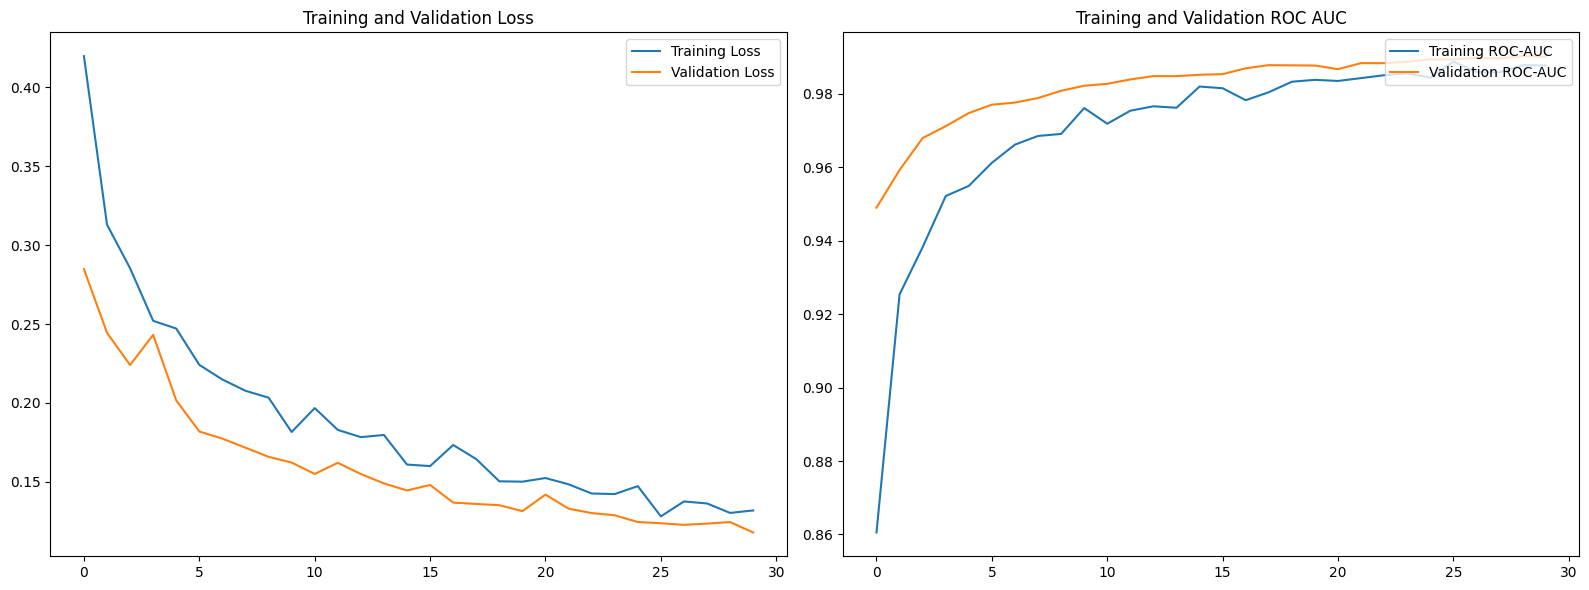

In [52]:
# Genning the roc auc
roc_auc = history.history['roc_auc']
val_roc_auc = history.history['val_roc_auc']

# Getting the losses
loss = history.history['loss']
val_loss = history.history['val_loss']

# No. of epochs it trained
epochs_range = history.epoch

# Plotting Training and Validation accuracy
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Plotting Training and Validation Loss
ax[0].plot(epochs_range, loss, label='Training Loss')
ax[0].plot(epochs_range, val_loss, label='Validation Loss')
ax[0].legend(loc='upper right')
ax[0].set_title('Training and Validation Loss')

# Plotting Training and Validation ROC AUC
ax[1].plot(epochs_range, roc_auc, label='Training ROC-AUC')
ax[1].plot(epochs_range, val_roc_auc, label='Validation ROC-AUC')
ax[1].legend(loc='upper right')
ax[1].set_title('Training and Validation ROC AUC')

plt.tight_layout()
plt.show()

## Evaluate Model

In [53]:
loss, roc_auc_score = model.evaluate(test_ds, verbose=0)
print(f"\nROC-AUC:   {roc_auc_score:.5f}", 
      f"Loss:      {loss:.5f}\n", sep="\n")


ROC-AUC:   0.90064
Loss:      0.44157



In [54]:
def plot_confusion_matrix(ax, cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):

    print(cm)

    ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title)
    # ax.colorbar()
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(classes)
    ax.set_yticklabels(classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    

def plot_roc_curve(ax, fpr, tpr, roc_auc):

    ax.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    # ax.set_title('Receiver Operating Characteristic for Class: ')
    ax.legend(loc="lower right")
    

def evaluate_model_on_dataset(model, dataset, thres=0.5):
    true_labels = []
    predicted_probs = []

    for batch in dataset:
        images, labels = batch
        true_labels.extend(labels.numpy())
        predictions = model.predict(images)
        predicted_probs.extend(predictions)

    true_labels = np.array(true_labels)
    predicted_probs = np.array(predicted_probs)

    predicted_classes = (predicted_probs > thres).astype('int')

    # Calculate confusion matrix
    confusion_mtx = confusion_matrix(true_labels, predicted_classes)

    # Calculate ROC curve and AUC score
    fpr_curve, tpr_curve, _ = roc_curve(true_labels, predicted_probs)
    roc_auc = AUC(fpr_curve, tpr_curve)

    return confusion_mtx, fpr_curve, tpr_curve, roc_auc, thres

1/1 [==============================] - 0s 29ms/step
[[ 484  240]
 [ 170 1509]]


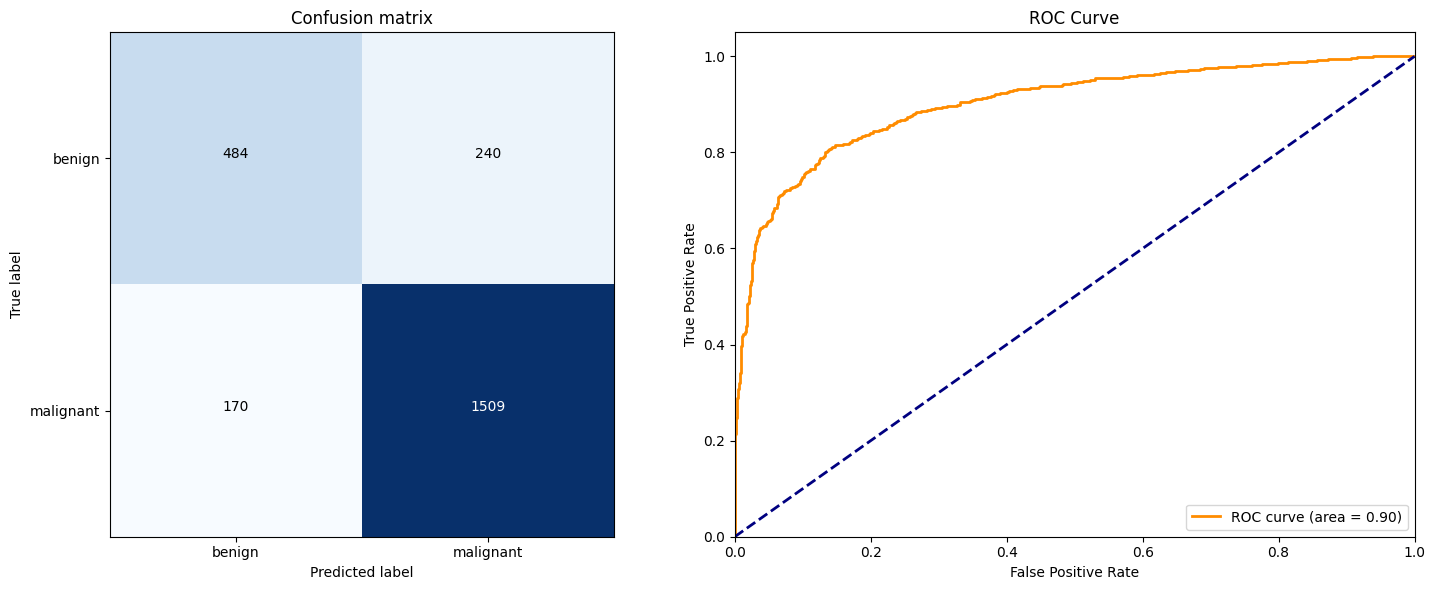

In [55]:
# Evaluate the model on the dataset and get evaluation results
confusion_mtx, fpr, tpr, roc_auc, thresholds = evaluate_model_on_dataset(model, test_ds, thres=0.3)
# print(f"Optimal Threshold: {optimal_threshold}")
# Plot confusion matrix and ROC curve
class_names = ["benign", "malignant"]  # Modify based on your classes
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Plot confusion matrix
plot_confusion_matrix(axs[0], confusion_mtx, class_names)

# Plot ROC curve
plot_roc_curve(axs[1], fpr, tpr, roc_auc)
axs[1].set_title('ROC Curve')

plt.tight_layout()
plt.show()